### Apprentissage profond - TD n°2
__________
Architectures DNN classiques appliquées à la classification de chiffres avec MNIST

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# we use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Données et problème

On réutilise le dataset MNIST déjà téléchargé au TD précédent. Cette fois-ci, on va charger les données avec le module `Dataloader` de pytorch.

In [3]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

my_data_path = '/home/efeillet/Code/TDDL-master/data'
train_set = datasets.MNIST( my_data_path, train=True, transform=trans, download=True )
test_set = datasets.MNIST( my_data_path, train=False, transform=trans, download=True )


Consulter la [documentation PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) à propos des modules `Dataset` et `Dataloader`.

NB : en pratique, on pourra définir [son propre dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) pour un cas d'utilisation donné.

In [4]:
# attributs du train set
var = vars(train_set)
for key in var.keys() : 
    print(key, type(var[key]))

print(train_set.data.shape)
print(train_set.targets.shape)

root <class 'str'>
transform <class 'torchvision.transforms.transforms.Compose'>
target_transform <class 'NoneType'>
transforms <class 'torchvision.datasets.vision.StandardTransform'>
train <class 'bool'>
data <class 'torch.Tensor'>
targets <class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.Size([60000])


In [5]:
# define data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))


total training batch number: 600
total testing batch number: 100


In [6]:
# attributs du train loader
var = vars(train_loader)
for key in var.keys() : 
    print(key, type(var[key]))

dataset <class 'torchvision.datasets.mnist.MNIST'>
num_workers <class 'int'>
prefetch_factor <class 'NoneType'>
pin_memory <class 'bool'>
pin_memory_device <class 'str'>
timeout <class 'int'>
worker_init_fn <class 'NoneType'>
_DataLoader__multiprocessing_context <class 'NoneType'>
_dataset_kind <class 'int'>
batch_size <class 'int'>
drop_last <class 'bool'>
sampler <class 'torch.utils.data.sampler.RandomSampler'>
batch_sampler <class 'torch.utils.data.sampler.BatchSampler'>
generator <class 'NoneType'>
collate_fn <class 'function'>
persistent_workers <class 'bool'>
_DataLoader__initialized <class 'bool'>
_IterableDataset_len_called <class 'NoneType'>
_iterator <class 'NoneType'>


Visualisation des images en utilisant le chargement des données avec `Dataloader`.

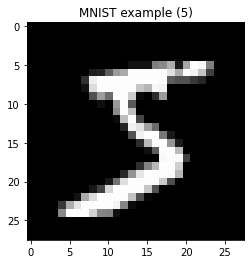

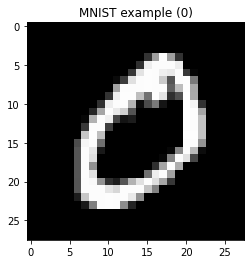

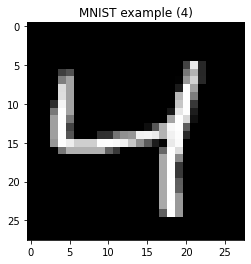

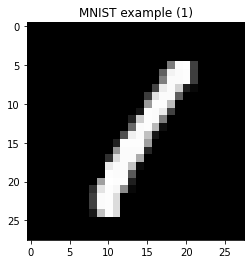

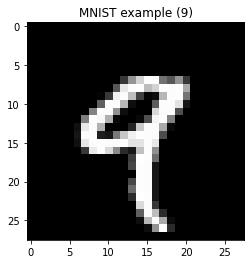

In [7]:
# display some images
# for an alternative see https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
for ii in range(5):
    imshow(train_set.data[ii] , title='MNIST example ({})'.format(train_set.targets[ii]) )
plt.close()

### Modélisation MLP

On commence par définir les tailles d'entrée et de sortie du réseau.

In [8]:
# définition des tailles d'entrée et de sortie
DATA_SIZE = 784 # 28 * 28 pixels
NUM_CLASSES = 10 # 10 classes

__Régression softmax__

Implémentation d'une classe `RegSoftNet` pour apprendre un modèle de régression softmax (généralisation à >  2 classesde la régression logistique).

Ici on utilise simplement 1 couche cachée.

In [9]:
class RegSoftNet(nn.Module):
    def __init__(self):
        super(RegSoftNet, self).__init__()
        self.fc = nn.Linear(DATA_SIZE,NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # passer de 28*28 à  (784,)
        x = F.relu(self.fc(x))
        return x

In [10]:
model = RegSoftNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

NB : Utilisation de model.train(), model.eval(), et with torch.no_grad()
* model.train() active les couches de type "dropout" ou "batchnorm". __Par défaut, tous les modules sont initialisés avec `train = True`__.
* model.eval() désactive la mise à jour des couches de type "dropout" ou "batchnorm".
* with torch.no_grad() économise de la mémoire et du temps de calcul au moment de l'inférence, dans la mesure où cela désactive la stockage des valeurs intermédiaires dans le graphe de calcul. Conserver en mémoire ces valeurs intermédiaires est utile pour effectuer la rétropropagation, mais inutile à l'inférence.

epoch 0 batch 0 [0/60000] training loss: 2.3934473991394043


epoch 0 batch 100 [10000/60000] training loss: 0.43571844696998596
epoch 0 batch 200 [20000/60000] training loss: 0.2791673541069031
epoch 0 batch 300 [30000/60000] training loss: 0.29807013273239136
epoch 0 batch 400 [40000/60000] training loss: 0.3239593207836151
epoch 0 batch 500 [50000/60000] training loss: 0.39623957872390747
Test Accuracy: 9132/10000 (tx 91.32%, err 8.68%)



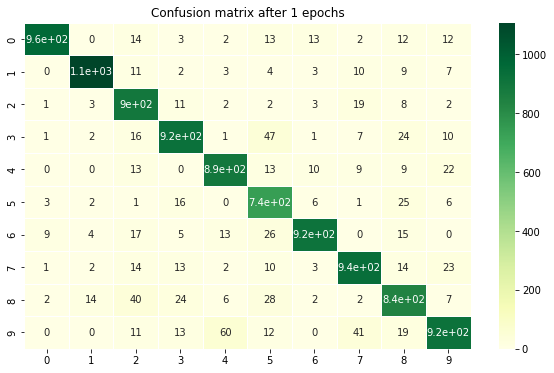

epoch 1 batch 0 [0/60000] training loss: 0.2780996859073639
epoch 1 batch 100 [10000/60000] training loss: 0.29870158433914185
epoch 1 batch 200 [20000/60000] training loss: 0.25270798802375793
epoch 1 batch 300 [30000/60000] training loss: 0.24130168557167053
epoch 1 batch 400 [40000/60000] training loss: 0.17425695061683655
epoch 1 batch 500 [50000/60000] training loss: 0.24506300687789917
Test Accuracy: 9214/10000 (tx 92.14%, err 7.86%)



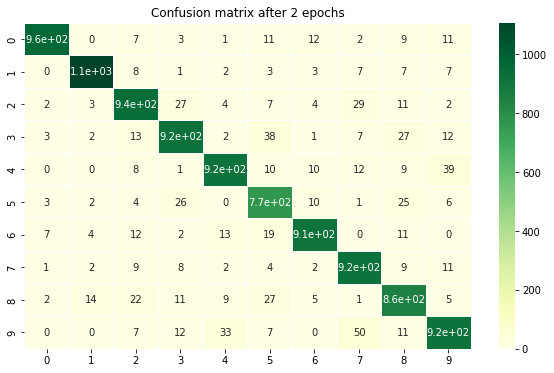

epoch 2 batch 0 [0/60000] training loss: 0.12241941690444946
epoch 2 batch 100 [10000/60000] training loss: 0.13692902028560638
epoch 2 batch 200 [20000/60000] training loss: 0.18382860720157623
epoch 2 batch 300 [30000/60000] training loss: 0.32954657077789307
epoch 2 batch 400 [40000/60000] training loss: 0.28287047147750854
epoch 2 batch 500 [50000/60000] training loss: 0.32372143864631653
Test Accuracy: 9209/10000 (tx 92.09%, err 7.91%)



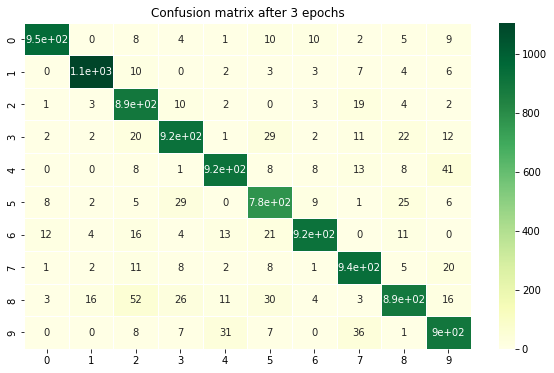

epoch 3 batch 0 [0/60000] training loss: 0.18640778958797455
epoch 3 batch 100 [10000/60000] training loss: 0.3461775481700897
epoch 3 batch 200 [20000/60000] training loss: 0.2728955149650574
epoch 3 batch 300 [30000/60000] training loss: 0.15389880537986755
epoch 3 batch 400 [40000/60000] training loss: 0.2941611409187317
epoch 3 batch 500 [50000/60000] training loss: 0.3177661597728729
Test Accuracy: 9227/10000 (tx 92.27%, err 7.73%)



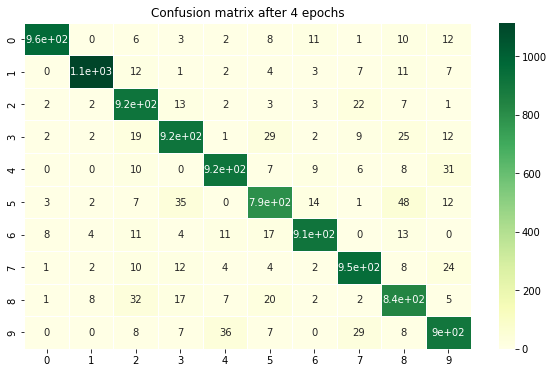

epoch 4 batch 0 [0/60000] training loss: 0.2811277508735657
epoch 4 batch 100 [10000/60000] training loss: 0.23530828952789307
epoch 4 batch 200 [20000/60000] training loss: 0.17464487254619598
epoch 4 batch 300 [30000/60000] training loss: 0.33571094274520874
epoch 4 batch 400 [40000/60000] training loss: 0.19756008684635162
epoch 4 batch 500 [50000/60000] training loss: 0.22418469190597534
Test Accuracy: 9219/10000 (tx 92.19%, err 7.81%)



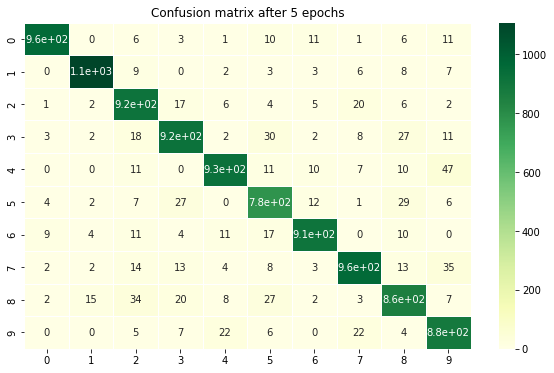

epoch 5 batch 0 [0/60000] training loss: 0.19728025794029236
epoch 5 batch 100 [10000/60000] training loss: 0.16726888716220856
epoch 5 batch 200 [20000/60000] training loss: 0.25397026538848877
epoch 5 batch 300 [30000/60000] training loss: 0.3095000386238098
epoch 5 batch 400 [40000/60000] training loss: 0.15591871738433838
epoch 5 batch 500 [50000/60000] training loss: 0.3308376371860504
Test Accuracy: 9223/10000 (tx 92.23%, err 7.77%)



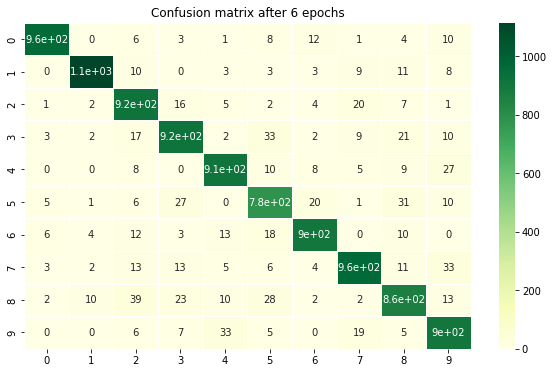

epoch 6 batch 0 [0/60000] training loss: 0.2985208034515381
epoch 6 batch 100 [10000/60000] training loss: 0.22616229951381683
epoch 6 batch 200 [20000/60000] training loss: 0.1751571148633957
epoch 6 batch 300 [30000/60000] training loss: 0.291284441947937
epoch 6 batch 400 [40000/60000] training loss: 0.3916516602039337
epoch 6 batch 500 [50000/60000] training loss: 0.19509637355804443
Test Accuracy: 9244/10000 (tx 92.44%, err 7.56%)



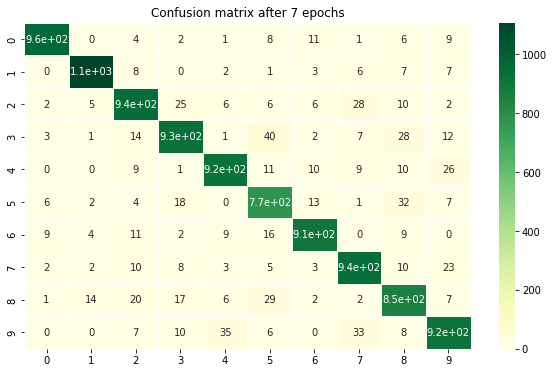

epoch 7 batch 0 [0/60000] training loss: 0.33782875537872314
epoch 7 batch 100 [10000/60000] training loss: 0.26136747002601624
epoch 7 batch 200 [20000/60000] training loss: 0.19998739659786224
epoch 7 batch 300 [30000/60000] training loss: 0.2170810103416443
epoch 7 batch 400 [40000/60000] training loss: 0.26688578724861145
epoch 7 batch 500 [50000/60000] training loss: 0.32126158475875854
Test Accuracy: 9244/10000 (tx 92.44%, err 7.56%)



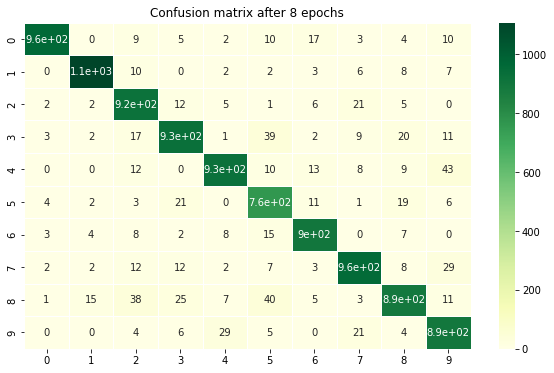

epoch 8 batch 0 [0/60000] training loss: 0.31536442041397095
epoch 8 batch 100 [10000/60000] training loss: 0.21497219800949097
epoch 8 batch 200 [20000/60000] training loss: 0.23390540480613708
epoch 8 batch 300 [30000/60000] training loss: 0.25375327467918396
epoch 8 batch 400 [40000/60000] training loss: 0.24796001613140106
epoch 8 batch 500 [50000/60000] training loss: 0.25885510444641113
Test Accuracy: 9250/10000 (tx 92.50%, err 7.50%)



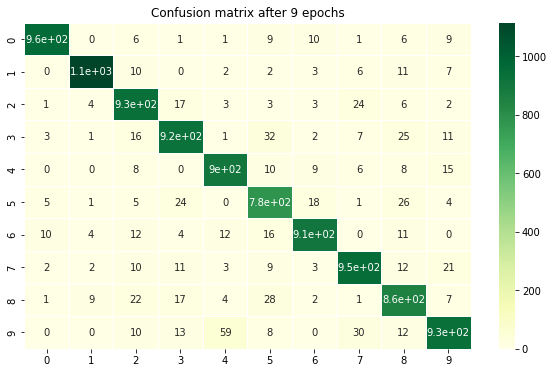

epoch 9 batch 0 [0/60000] training loss: 0.22668641805648804
epoch 9 batch 100 [10000/60000] training loss: 0.4976932108402252
epoch 9 batch 200 [20000/60000] training loss: 0.13727377355098724
epoch 9 batch 300 [30000/60000] training loss: 0.27274155616760254
epoch 9 batch 400 [40000/60000] training loss: 0.3056717813014984
epoch 9 batch 500 [50000/60000] training loss: 0.24322055280208588
Test Accuracy: 9242/10000 (tx 92.42%, err 7.58%)



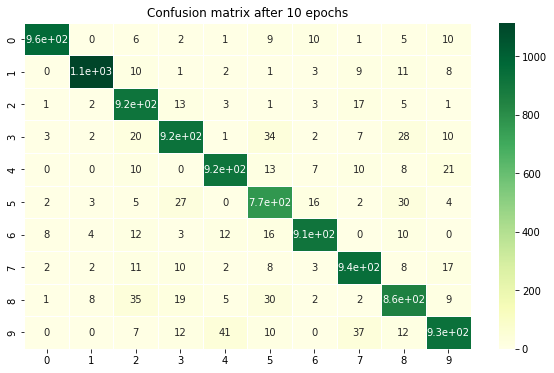

In [11]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    #print(confusion)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(confusion, annot=True,  linewidths=.5, cmap='YlGn')
    plt.title(f"Confusion matrix after {epoch+1} epochs")
    plt.show()
    plt.close()

__Perceptron multi-couche__

On utilise ici 2 couches cachées.

In [12]:
NUM_HIDDEN_1 = 256
NUM_HIDDEN_2 = 256

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(DATA_SIZE, NUM_HIDDEN_1)
        self.fc2 = nn.Linear(NUM_HIDDEN_1, NUM_HIDDEN_2)
        self.fc3 = nn.Linear(NUM_HIDDEN_2, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
model = MLPNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# redéfinir l'optimiseur ! 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

A nouveau, on entraine le modèle et on affiche au fur et à mesure des "epochs" la matrice de confusion sur les données d'évaluation. 

epoch 0 batch 0 [0/60000] training loss: 2.305556058883667


epoch 0 batch 100 [10000/60000] training loss: 0.48036953806877136
epoch 0 batch 200 [20000/60000] training loss: 0.39840441942214966
epoch 0 batch 300 [30000/60000] training loss: 0.3420241177082062
epoch 0 batch 400 [40000/60000] training loss: 0.17252089083194733
epoch 0 batch 500 [50000/60000] training loss: 0.3217950165271759
Test Accuracy: 9330/10000 (tx 93.30%, err 6.70%)



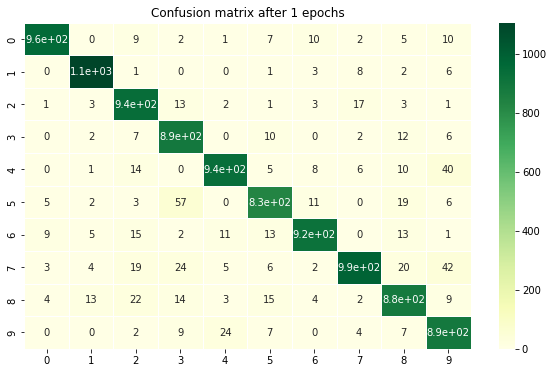

epoch 1 batch 0 [0/60000] training loss: 0.3474756181240082
epoch 1 batch 100 [10000/60000] training loss: 0.178324893116951
epoch 1 batch 200 [20000/60000] training loss: 0.22938276827335358
epoch 1 batch 300 [30000/60000] training loss: 0.20907709002494812
epoch 1 batch 400 [40000/60000] training loss: 0.112760029733181
epoch 1 batch 500 [50000/60000] training loss: 0.31121236085891724
Test Accuracy: 9535/10000 (tx 95.35%, err 4.65%)



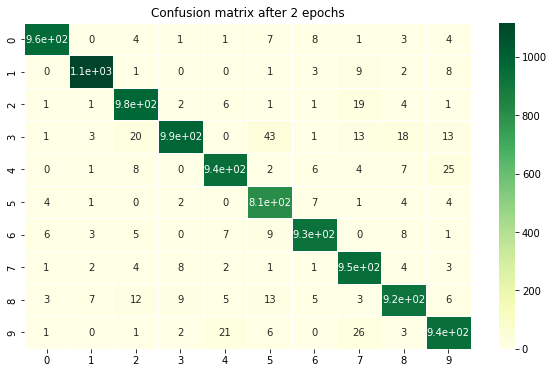

epoch 2 batch 0 [0/60000] training loss: 0.17392566800117493
epoch 2 batch 100 [10000/60000] training loss: 0.14079363644123077
epoch 2 batch 200 [20000/60000] training loss: 0.11720119416713715
epoch 2 batch 300 [30000/60000] training loss: 0.13918349146842957
epoch 2 batch 400 [40000/60000] training loss: 0.06698556244373322
epoch 2 batch 500 [50000/60000] training loss: 0.22742222249507904
Test Accuracy: 9652/10000 (tx 96.52%, err 3.48%)



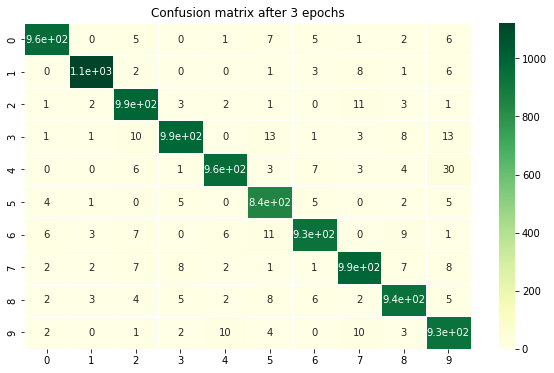

epoch 3 batch 0 [0/60000] training loss: 0.0781422108411789
epoch 3 batch 100 [10000/60000] training loss: 0.2558172643184662
epoch 3 batch 200 [20000/60000] training loss: 0.0556526742875576
epoch 3 batch 300 [30000/60000] training loss: 0.1652606725692749
epoch 3 batch 400 [40000/60000] training loss: 0.1798536330461502
epoch 3 batch 500 [50000/60000] training loss: 0.11682799458503723
Test Accuracy: 9675/10000 (tx 96.75%, err 3.25%)



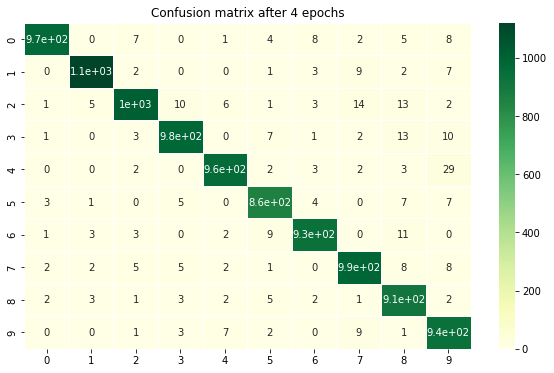

epoch 4 batch 0 [0/60000] training loss: 0.1044204980134964
epoch 4 batch 100 [10000/60000] training loss: 0.10716710239648819
epoch 4 batch 200 [20000/60000] training loss: 0.08539990335702896
epoch 4 batch 300 [30000/60000] training loss: 0.0734318345785141
epoch 4 batch 400 [40000/60000] training loss: 0.09938627481460571
epoch 4 batch 500 [50000/60000] training loss: 0.1357342004776001
Test Accuracy: 9733/10000 (tx 97.33%, err 2.67%)



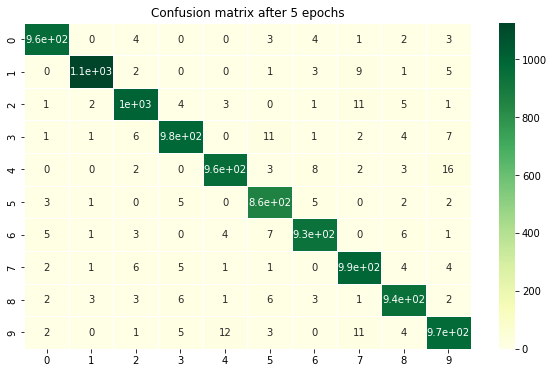

epoch 5 batch 0 [0/60000] training loss: 0.014893190935254097
epoch 5 batch 100 [10000/60000] training loss: 0.04907631501555443
epoch 5 batch 200 [20000/60000] training loss: 0.15254729986190796
epoch 5 batch 300 [30000/60000] training loss: 0.125503808259964
epoch 5 batch 400 [40000/60000] training loss: 0.18211299180984497
epoch 5 batch 500 [50000/60000] training loss: 0.08416976034641266
Test Accuracy: 9720/10000 (tx 97.20%, err 2.80%)



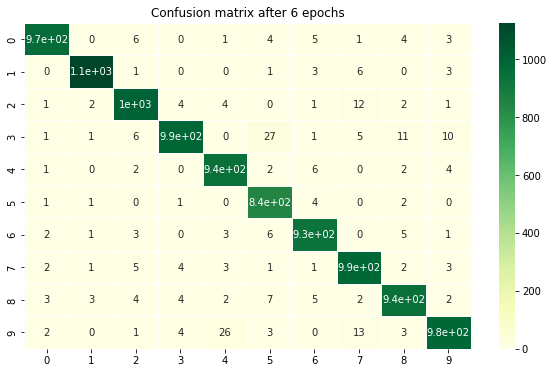

epoch 6 batch 0 [0/60000] training loss: 0.06407534331083298
epoch 6 batch 100 [10000/60000] training loss: 0.0552326999604702
epoch 6 batch 200 [20000/60000] training loss: 0.05810629948973656
epoch 6 batch 300 [30000/60000] training loss: 0.028289316222071648
epoch 6 batch 400 [40000/60000] training loss: 0.07739512622356415
epoch 6 batch 500 [50000/60000] training loss: 0.06620655208826065
Test Accuracy: 9742/10000 (tx 97.42%, err 2.58%)



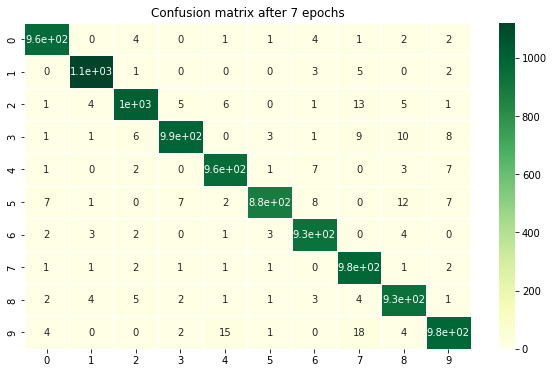

epoch 7 batch 0 [0/60000] training loss: 0.053498994559049606
epoch 7 batch 100 [10000/60000] training loss: 0.07611014693975449
epoch 7 batch 200 [20000/60000] training loss: 0.0371275320649147
epoch 7 batch 300 [30000/60000] training loss: 0.08335751295089722
epoch 7 batch 400 [40000/60000] training loss: 0.1128755509853363
epoch 7 batch 500 [50000/60000] training loss: 0.059787020087242126
Test Accuracy: 9772/10000 (tx 97.72%, err 2.28%)



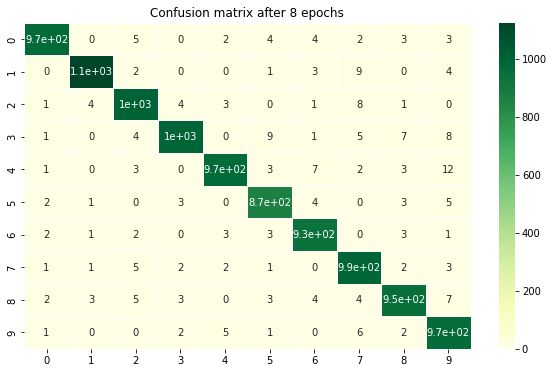

epoch 8 batch 0 [0/60000] training loss: 0.051545385271310806
epoch 8 batch 100 [10000/60000] training loss: 0.018496889621019363
epoch 8 batch 200 [20000/60000] training loss: 0.05124538764357567
epoch 8 batch 300 [30000/60000] training loss: 0.06744050979614258
epoch 8 batch 400 [40000/60000] training loss: 0.017504805698990822
epoch 8 batch 500 [50000/60000] training loss: 0.05236329138278961
Test Accuracy: 9788/10000 (tx 97.88%, err 2.12%)



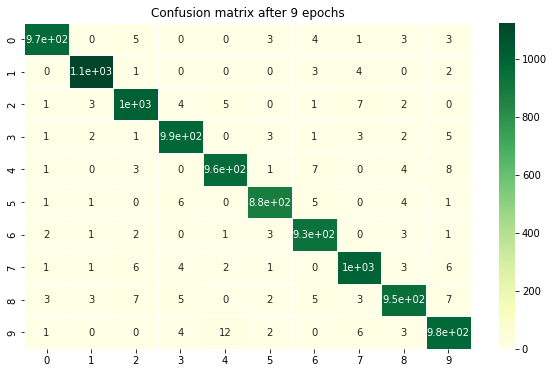

epoch 9 batch 0 [0/60000] training loss: 0.014763165265321732
epoch 9 batch 100 [10000/60000] training loss: 0.007981332950294018
epoch 9 batch 200 [20000/60000] training loss: 0.03411385044455528
epoch 9 batch 300 [30000/60000] training loss: 0.03409508243203163
epoch 9 batch 400 [40000/60000] training loss: 0.021238189190626144
epoch 9 batch 500 [50000/60000] training loss: 0.038917798548936844
Test Accuracy: 9770/10000 (tx 97.70%, err 2.30%)



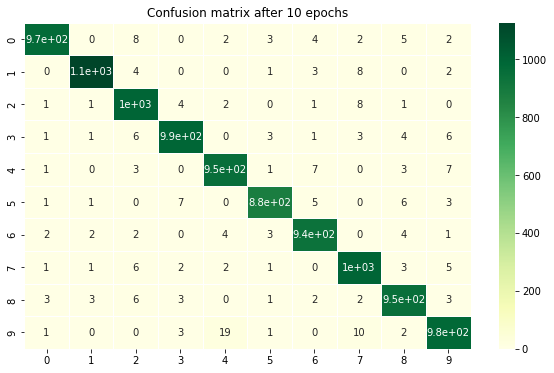

In [14]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    #print(confusion)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(confusion, annot=True,  linewidths=.5, cmap='YlGn')
    plt.title(f"Confusion matrix after {epoch+1} epochs")
    plt.show()
    plt.close()

### Modélisation CNN

Consulter la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d) de la class `Conv2D`.

> class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

Taille d'entrée : (N,Cin,H,W) x (N,Cin​,H,W) 

Taille de sortie : (N,Cout,Hout,Wout) x (N,Cout​,Hout​,Wout​)

avec : 
* N : batch size
* Cin et Cout : nombre de filtres respectivement en entrée et sortie (channels)
* H et W : height and width des filtres en entrée
* Hout et Wout : height and width des filtres en sortie

Attention : calcul des dimensions de sortie des couches de convolution et de pooling.

In [15]:
# Implémentation d'un CNN avec deux couches convolutives
# v1 sans Dropout
# v2 ajouter une couche de Dropout après les 2 couches de conv

NUM_CONV_1=10 # try 32
NUM_CONV_2=20 # try 64
NUM_FC=500 # try 1024

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,NUM_CONV_1,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        # self.drop = nn.Dropout2d()
        self.fc_1 = nn.Linear(4*4*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        # x = F.relu(self.drop(self.conv_2(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,4*4*NUM_CONV_2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x



NB : de manière équivalente, en utilisant `loss = F.nll_loss(output, target)` au lieu de `loss = CrossEntropyLoss()` on peut écrire :

> return F.log_softmax(x, dim=1)

In [16]:
model = CNNNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

epoch 0 batch 0 [0/60000] training loss: 2.300417900085449


epoch 0 batch 100 [10000/60000] training loss: 0.48475879430770874
epoch 0 batch 200 [20000/60000] training loss: 0.1592799723148346
epoch 0 batch 300 [30000/60000] training loss: 0.13753926753997803
epoch 0 batch 400 [40000/60000] training loss: 0.1139759048819542
epoch 0 batch 500 [50000/60000] training loss: 0.08705857396125793
Test Accuracy: 9724/10000 (tx 97.24%, err 2.76%)



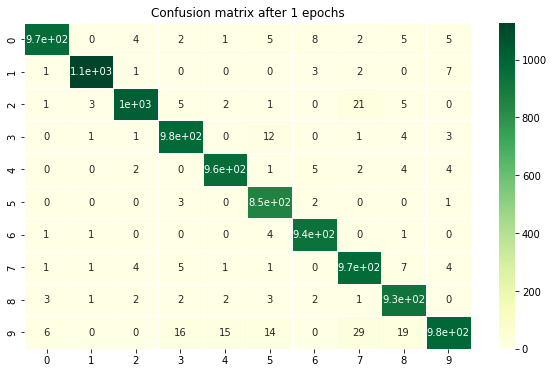

epoch 1 batch 0 [0/60000] training loss: 0.05467145889997482
epoch 1 batch 100 [10000/60000] training loss: 0.07065164297819138
epoch 1 batch 200 [20000/60000] training loss: 0.09382753074169159
epoch 1 batch 300 [30000/60000] training loss: 0.16059331595897675
epoch 1 batch 400 [40000/60000] training loss: 0.10161039233207703
epoch 1 batch 500 [50000/60000] training loss: 0.06432357430458069
Test Accuracy: 9834/10000 (tx 98.34%, err 1.66%)



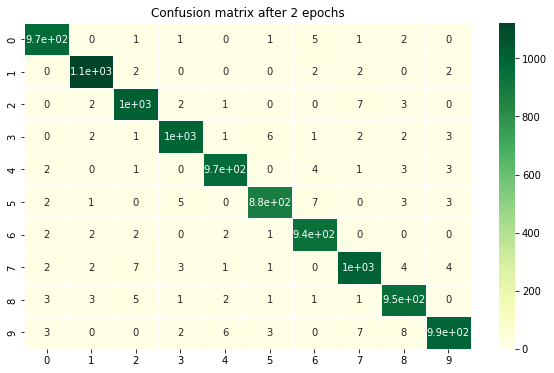

epoch 2 batch 0 [0/60000] training loss: 0.022652054205536842
epoch 2 batch 100 [10000/60000] training loss: 0.032117847353219986
epoch 2 batch 200 [20000/60000] training loss: 0.03049863874912262
epoch 2 batch 300 [30000/60000] training loss: 0.011255394667387009
epoch 2 batch 400 [40000/60000] training loss: 0.03969618305563927
epoch 2 batch 500 [50000/60000] training loss: 0.009927107952535152
Test Accuracy: 9865/10000 (tx 98.65%, err 1.35%)



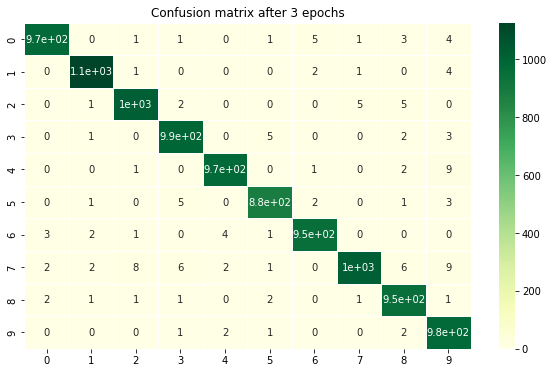

epoch 3 batch 0 [0/60000] training loss: 0.050229623913764954
epoch 3 batch 100 [10000/60000] training loss: 0.0822247564792633
epoch 3 batch 200 [20000/60000] training loss: 0.043860211968421936
epoch 3 batch 300 [30000/60000] training loss: 0.030041249468922615
epoch 3 batch 400 [40000/60000] training loss: 0.02878377214074135
epoch 3 batch 500 [50000/60000] training loss: 0.036812301725149155
Test Accuracy: 9860/10000 (tx 98.60%, err 1.40%)



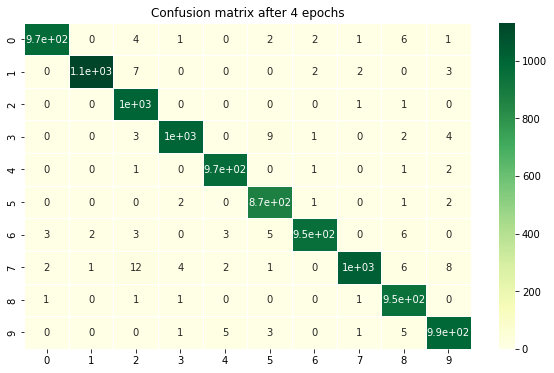

epoch 4 batch 0 [0/60000] training loss: 0.021548693999648094
epoch 4 batch 100 [10000/60000] training loss: 0.04466162249445915
epoch 4 batch 200 [20000/60000] training loss: 0.03325282037258148
epoch 4 batch 300 [30000/60000] training loss: 0.03285086899995804
epoch 4 batch 400 [40000/60000] training loss: 0.01655130460858345
epoch 4 batch 500 [50000/60000] training loss: 0.03499027341604233
Test Accuracy: 9891/10000 (tx 98.91%, err 1.09%)



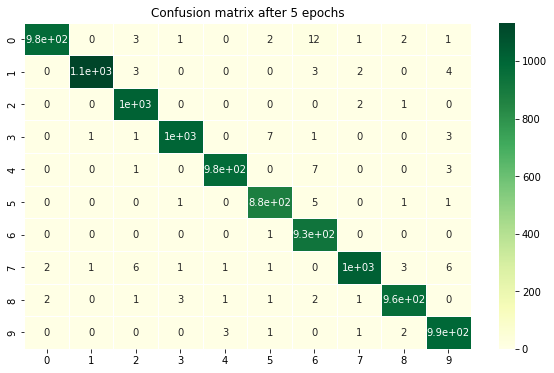

epoch 5 batch 0 [0/60000] training loss: 0.005210214294493198
epoch 5 batch 100 [10000/60000] training loss: 0.03991975635290146
epoch 5 batch 200 [20000/60000] training loss: 0.02408837154507637
epoch 5 batch 300 [30000/60000] training loss: 0.05774569883942604
epoch 5 batch 400 [40000/60000] training loss: 0.024779586121439934
epoch 5 batch 500 [50000/60000] training loss: 0.017267834395170212
Test Accuracy: 9899/10000 (tx 98.99%, err 1.01%)



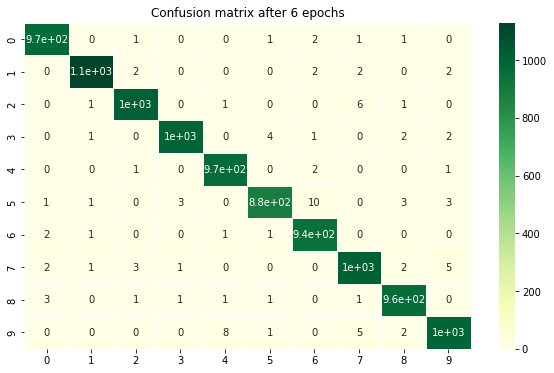

epoch 6 batch 0 [0/60000] training loss: 0.006897534243762493
epoch 6 batch 100 [10000/60000] training loss: 0.01084259245544672
epoch 6 batch 200 [20000/60000] training loss: 0.07232648134231567
epoch 6 batch 300 [30000/60000] training loss: 0.03820082172751427
epoch 6 batch 400 [40000/60000] training loss: 0.0031597933266311884
epoch 6 batch 500 [50000/60000] training loss: 0.12594425678253174
Test Accuracy: 9907/10000 (tx 99.07%, err 0.93%)



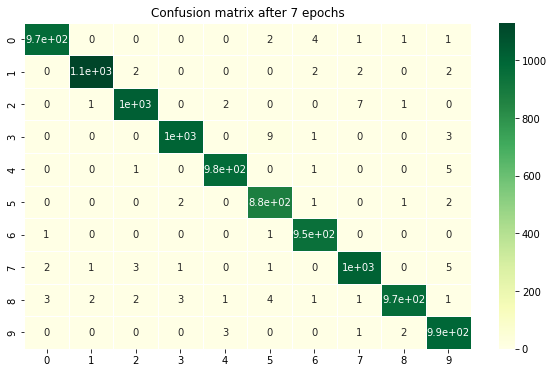

epoch 7 batch 0 [0/60000] training loss: 0.004778894130140543
epoch 7 batch 100 [10000/60000] training loss: 0.01715526543557644
epoch 7 batch 200 [20000/60000] training loss: 0.01298199500888586
epoch 7 batch 300 [30000/60000] training loss: 0.00701352022588253
epoch 7 batch 400 [40000/60000] training loss: 0.010618737898766994
epoch 7 batch 500 [50000/60000] training loss: 0.018781131133437157
Test Accuracy: 9909/10000 (tx 99.09%, err 0.91%)



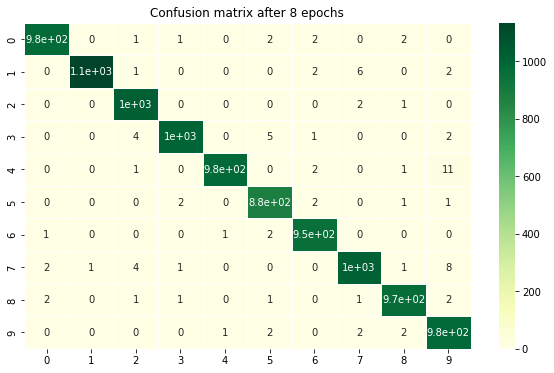

epoch 8 batch 0 [0/60000] training loss: 0.013609487563371658
epoch 8 batch 100 [10000/60000] training loss: 0.0035831930581480265
epoch 8 batch 200 [20000/60000] training loss: 0.003314741887152195
epoch 8 batch 300 [30000/60000] training loss: 0.004714928101748228
epoch 8 batch 400 [40000/60000] training loss: 0.0038666874170303345
epoch 8 batch 500 [50000/60000] training loss: 0.02306603640317917
Test Accuracy: 9899/10000 (tx 98.99%, err 1.01%)



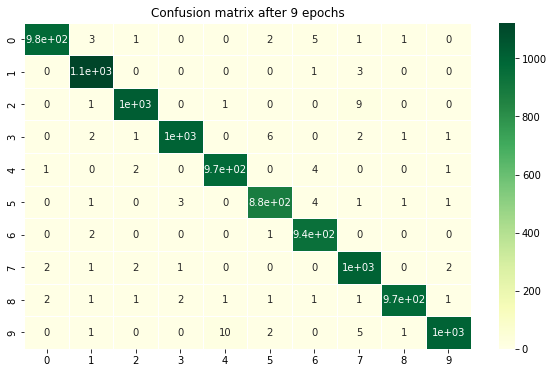

epoch 9 batch 0 [0/60000] training loss: 0.016211118549108505
epoch 9 batch 100 [10000/60000] training loss: 0.003379808971658349
epoch 9 batch 200 [20000/60000] training loss: 0.015587844885885715
epoch 9 batch 300 [30000/60000] training loss: 0.01341947540640831
epoch 9 batch 400 [40000/60000] training loss: 0.032872866839170456
epoch 9 batch 500 [50000/60000] training loss: 0.008903870359063148
Test Accuracy: 9892/10000 (tx 98.92%, err 1.08%)



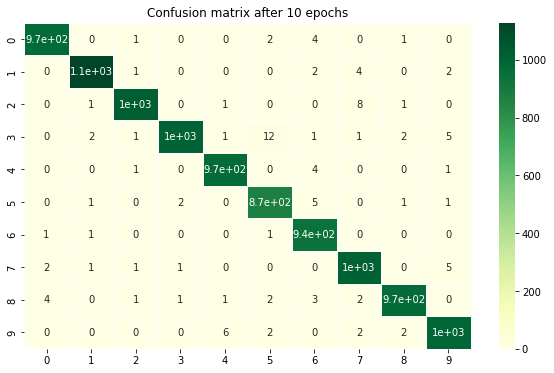

In [17]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    #print(confusion)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(confusion, annot=True,  linewidths=.5, cmap='YlGn')
    plt.title(f"Confusion matrix after {epoch+1} epochs")
    plt.show()
    plt.close()

__Calcul de la taille d'un modèle__

In [18]:
# parametres + buffers (e.g. batch norm)

def get_model_size(model):
    """ 
    in megabites --> divide by 1024**2
    """
    param_size = 0
    for p in model.parameters() :
        param_size += p.numel()*p.element_size()

    buffer_size = 0
    for b in model.buffers() :
        buffer_size += b.numel()*b.element_size()

    return (param_size + buffer_size) / 1024**2

print(round(get_model_size(model),3), "MB")

0.652 MB


In [19]:
#variantes (nombre de params) --> sélection suivant requires_grad

def count_trainable_parameters(model):
    """ count the number of trainable parameters""" 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_all_parameters(model):
    """ count the number of parameters, trainable or not""" 
    return sum(p.numel() for p in model.parameters())

print(count_trainable_parameters(model))
print(count_all_parameters(model))


170790
170790


__Sauvegarde des poids du modèle__

Il y a deux manières de sauvegarder un modèle suivant si on utilise `state_dict()` ou pas. Comparer avec la [documentation PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

> A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

In [20]:
# sauvegarde
print(model)
torch.save(model, 'my_cnn.pth')

# chargement
model1 = torch.load('./my_cnn.pth')
print(model1)

CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)
CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)


In [21]:
# Utilisation de state_dict : on accède aux paramètres du modèle

# sauvegarde
print(model.state_dict().keys())
torch.save(model.state_dict(), 'my_cnn_params.pth')

# chargement : il faut définir le modèle puis charger les poids
model2 = CNNNet()
model2.load_state_dict(torch.load('my_cnn_params.pth'))
print(model2)

odict_keys(['conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'fc_1.weight', 'fc_1.bias', 'fc_2.weight', 'fc_2.bias'])
CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)


__Visualisation des feature maps (cartes d'activation)__

Se référer au script `visualize_cnn_features.py`. Il utilise les poids du CNN, que l'on vient de sauvegarder. 

Autres références pour visualiser les cartes d'activation d'un CNN : [un réseau plus profond](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)  et [une autre méthode de visualisation](https://blbadger.github.io/feature-visualization.html) (en optimisant l'entrée de manière à maximiser la réponse d'un filtre donné).

### Modèles LSTM et Bi-LSTM

Se référer à la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) pour le module `LSTM`.

__LSTM__

In [22]:
# Hyper-parameters
sequence_length = 28 # on voit une image comme une chaine de 28 mots
input_size = 28 # chaque mot fait 28 caractères
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.001

In [23]:
# define LSTM model
class LSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(LSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True)
        self.fc = nn.Linear(hidden_size,nb_classes)

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [24]:
model = LSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()


In [25]:
import time 

# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )



Epoch [1/2], Step [100/600], Loss: 0.2766 (8.19 s)
Epoch [1/2], Step [200/600], Loss: 0.2464 (16.45 s)
Epoch [1/2], Step [300/600], Loss: 0.0957 (24.33 s)
Epoch [1/2], Step [400/600], Loss: 0.1044 (32.30 s)
Epoch [1/2], Step [500/600], Loss: 0.2041 (40.15 s)
Epoch [1/2], Step [600/600], Loss: 0.1333 (47.87 s)
Epoch [2/2], Step [100/600], Loss: 0.0443 (55.42 s)
Epoch [2/2], Step [200/600], Loss: 0.1808 (63.33 s)
Epoch [2/2], Step [300/600], Loss: 0.1482 (71.22 s)
Epoch [2/2], Step [400/600], Loss: 0.0739 (78.97 s)
Epoch [2/2], Step [500/600], Loss: 0.1761 (86.87 s)
Epoch [2/2], Step [600/600], Loss: 0.1768 (94.74 s)
Test Accuracy: 97.11%


__BiLSTM__

On passe l'option "bidirectional" à "True" dans nn.LSTM, et on adapte les dimensions des tenseurs dans le réseau.

In [26]:
learning_rate = 0.0005 # for BiLSTM

In [27]:
# define BiLSTM model
class BiLSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(BiLSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2,nb_classes)  # 2 for bidirection

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [28]:
model = BiLSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [29]:
# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )

Epoch [1/2], Step [100/600], Loss: 0.3756 (11.69 s)
Epoch [1/2], Step [200/600], Loss: 0.1829 (22.92 s)
Epoch [1/2], Step [300/600], Loss: 0.0595 (33.73 s)
Epoch [1/2], Step [400/600], Loss: 0.1961 (45.05 s)
Epoch [1/2], Step [500/600], Loss: 0.1752 (56.02 s)
Epoch [1/2], Step [600/600], Loss: 0.2056 (67.15 s)
Epoch [2/2], Step [100/600], Loss: 0.3366 (79.05 s)
Epoch [2/2], Step [200/600], Loss: 0.1145 (90.83 s)
Epoch [2/2], Step [300/600], Loss: 0.1488 (102.30 s)
Epoch [2/2], Step [400/600], Loss: 0.0795 (114.22 s)
Epoch [2/2], Step [500/600], Loss: 0.1376 (125.41 s)
Epoch [2/2], Step [600/600], Loss: 0.2321 (136.88 s)
Test Accuracy: 96.15%
